In [1]:
import psycopg2
import pandas as pd
from pandas import DataFrame
from pandas import concat
from pandas import Series

import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import itertools

import numpy
from numpy import concatenate
from numpy import array

import seaborn as sns

import math
from math import sqrt

# ARIMA AND LSTM STUFF
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tools.eval_measures import rmse

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

import time
import statsmodels.api as sm
import warnings

Using TensorFlow backend.


# Model generation for app 

It was decided to use years **2016 - 2019** to train the model having a **batch size 
of 72**, **epochs 30** and **neurons** equal to **n_features **(19)*4**. The **4** value is result of the use of
it during univariate analysis. Also the year 2019 was defined to be the validation set when training the model.

When setting the value for batch size. It was decided that model needs **3 days of information (72 hrs)** to predict  **1 hour in the future**. This is defined in the variable **input_t_reframed = 72** when passed as a parameter for method **series_to_supervised**. 
Batch size has the same value that was found to give relative better results compared with other batch sizes. 

To get higher accuracy a **one step batch size is suggested** as it was shown in the univariate LSTM model. 

The app will take the easiest approach having batch size of **72 hours** predicting **1 hour** in the future applying the same idea explained on **univariate LSTM** using a multi step frame that is moved by steps of 72 hrs, to predict 1 hour.


# Load data from database and train models   

In [5]:
connection = psycopg2.connect(user = "equipo7",
                            password = "DLgndXy2m4hbWH-qn-Co",
                            host= "ds4a-demo-instance.cssn41frspmj.us-east-1.rds.amazonaws.com",
                            port = "5432",
                            database = "anahuac")
cursor = connection.cursor()
def runquery(query):
    df=pd.read_sql(query,connection)
    return df


def pivot_by_factor(df, index_table, column_table, value_table):
    df = pd.pivot_table(df, index = index_table, columns = column_table, values = value_table)
    df = df.sort_index(axis=1, level=1)
    df.columns = [f'{b}_{a}' for a, b in df.columns]
    df = df.reset_index()
    return df

where_date_clause = " WHERE date >= '2016-01-01' AND date <= '2020-03-01 00:00:00' ORDER BY date"; 

sqlQuery_workspace = "select * from final_table.metrics_compact " + where_date_clause
df_workspace = pd.DataFrame(runquery(sqlQuery_workspace))
pd.options.display.max_columns = 999
df_workspace.describe()

,weekday,hora,co_st0,co_st1,co_st2,no_st0,no_st1,no_st2,no2_st0,no2_st1,no2_st2,nox_st0,nox_st1,nox_st2,o3_st0,o3_st1,o3_st2,pm10_st0,pm10_st1,pm10_st2,pm25_st0,pm25_st1,pm25_st2,pmco_st0,pmco_st1,pmco_st2,so2_st0,so2_st1,so2_st2,rh_st0,rh_st1,rh_st2,tmp_st0,tmp_st1,tmp_st2,wdr_st0,wdr_st1,wdr_st2,wsp_st0,wsp_st1,wsp_st2,pa_st0,pa_st1,pa_st2,uva_st0,uva_st1,uva_st2,uvb_st0,uvb_st1,uvb_st2,dewp_st0,dewp_st1,dewp_st2
count,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000
mean,3.000684,11.500000,2.009821,2.010781,1.933276,16.290871,17.892237,13.826872,20.581248,23.166810,24.844024,34.997769,39.483427,37.088453,26.760183,25.426157,28.150542,43.685839,40.538009,35.876577,21.941265,20.120711,20.920374,25.642988,18.323605,17.347148,4.282464,6.454359,4.994741,49.549373,48.429123,46.339284,16.461610,16.134679,16.686782,141.947113,183.185015,155.311226,3.230649,3.375529,3.455426,584.903921,584.903921,584.903921,1.135074,1.135074,1.135074,0.861387,0.861387,0.861387,7.445478,7.445478,7.445478
std,2.001226,6.922285,1.022476,0.995962,0.919286,22.399182,24.898704,17.875556,8.919408,10.603636,10.558123,27.951730,31.744354,24.819787,22.150187,22.072536,25.096834,23.719758,22.211365,17.772913,12.230730,9.811524,11.007447,16.073013,9.334452,9.287875,4.452126,7.550065,5.581248,17.213118,18.017101,16.466171,4.542484,4.771222,4.179152,51.031936,64.470116,66.101057,1.597564,1.607968,1.608401,1.498553,1.498553,1.498553,1.582721,1.582721,1.582721,1.338455,1.338455,1.338455,4.014396,4.014396,4.014396
min,0.000000,0.000000,0.014286,0.014286,0.012500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.500000,0.455464,0.666667,1.500000,0.000000,0.000000,0.500000,0.000000,0.875000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.444440,4.833330,5.333330,2.500000,2.033330,3.142860,5.250000,9.666670,8.166670,0.444444,0.400000,0.442857,577.000000,577.000000,577.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-7.503700,-7.503700,-7.503700
25%,1.000000,5.750000,1.354550,1.350000,1.283330,4.571430,4.857140,4.000000,13.857100,15.625000,17.500000,16.875000,19.305800,20.250000,8.000000,7.600000,7.888890,26.596150,24.833300,23.000000,13.600000,13.333300,13.200000,15.333300,12.000000,11.000000,2.333330,2.875000,2.555560,36.125000,33.833300,33.200000,13.187500,12.542900,13.457100,106.797500,137.000000,105.000000,1.777700,1.850000,1.971430,584.000000,584.000000,584.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.064958,5.064958,5.064958
50%,3.000000,11.500000,1.975000,2.022220,1.971430,7.333330,8.000000,6.625000,19.555600,21.375000,23.500000,25.875000,29.206250,30.125000,20.428600,18.333300,19.500000,39.400000,36.111100,33.000000,19.750000,18.500000,19.142900,22.000000,17.000000,15.750000,3.250000,3.888890,3.444440,51.444400,50.285700,47.500000,16.522200,16.271400,16.733300,137.250000,192.286000,146.857000,3.133330,3.428570,3.366670,584.965000,584.965000,584.965000,0.059083,0.059083,0.059083,0.012536,0.012536,0.012536,7.600000,7.600000,7.600000
75%,5.000000,17.250000,2.662500,2.687500,2.571430,17.625000,19.333300,16.000000,26.000000,28.777800,30.555600,43.125000,48.000000,46.285700,41.625000,38.543675,42.888900,56.166700,51.125000,45.666700,27.625000,25.000000,26.400000,32.000000,23.000000,22.000000,4.500000,6.605000,4.857140,63.878475,64.000000,60.000000,19.871400,19.783300,1

In [6]:
# set date as index
df_workspace.set_index('date', inplace=True)

In [7]:
df_workspace.head()

,fecha,weekday,hora,co_st0,co_st1,co_st2,no_st0,no_st1,no_st2,no2_st0,no2_st1,no2_st2,nox_st0,nox_st1,nox_st2,o3_st0,o3_st1,o3_st2,pm10_st0,pm10_st1,pm10_st2,pm25_st0,pm25_st1,pm25_st2,pmco_st0,pmco_st1,pmco_st2,so2_st0,so2_st1,so2_st2,rh_st0,rh_st1,rh_st2,tmp_st0,tmp_st1,tmp_st2,wdr_st0,wdr_st1,wdr_st2,wsp_st0,wsp_st1,wsp_st2,pa_st0,pa_st1,pa_st2,uva_st0,uva_st1,uva_st2,uvb_st0,uvb_st1,uvb_st2,dewp_st0,dewp_st1,dewp_st2
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-01 00:00:00,2016-01-01,4,0,1.30000,1.14,1.1250,22.2,18.8333,8.44444,38.8,39.8333,42.8889,61.0,58.6667,51.3333,7.500,3.50000,7.22222,133.833,168.667,79.4,85.1974,74.25,63.3698,43.3333,23.25,19.00,10.0000,21.1667,13.9842,56.7778,56.2857,50.0160,13.6000,12.7429,14.0994,141.6670,229.429,100.7750,1.10000,0.90000,0.91477,585.40,585.40,585.40,0.0,0.0,0.0,0.0,0.0,0.0,4.35273,4.35273,4.35273
2016-01-01 01:00:00,2016-01-01,4,1,1.56667,1.40,1.4125,25.6,17.6667,12.11110,37.0,37.6667,44.2222,62.6,55.1667,56.1111,4.625,3.50000,5.77778,172.333,163.667,112.0,125.7500,97.75,81.8571,51.3333,29.75,25.25,25.5000,19.3333,10.5961,59.2222,59.8571,51.6035,13.0667,12.2429,13.8274,93.6667,253.143,50.8366,1.21111,1.28571,1.00097,585.20,585.20,585.20,0.0,0.0,0.0,0.0,0.0,0.0,4.42452,4.42452,4.42452
2016-01-01 02:00:00,2016-01-01,4,2,1.68333,1.58,1.5000,30.0,25.3333,17.55560,36.0,35.5000,40.7778,65.6,60.6667,58.0000,3.625,3.50000,4.11111,186.000,149.000,137.4,130.0000,121.50,99.8571,46.3333,39.00,25.25,44.5000,25.3333,15.4286,62.5556,63.5714,53.3333,12.4556,11.4000,12.9333,84.3333,248.143,142.8330,1.55556,1.35714,1.43333,584.75,584.75,584.75,0.0,0.0,0.0,0.0,0.0,0.0,4.22699,4.22699,4.22699
2016-01-01 03:00:00,2016-01-01,4,3,1.63333,1.88,1.5875,29.4,29.3333,20.44440,33.4,33.1667,39.4444,62.6,62.0000,59.5556,4.625,3.33333,3.77778,140.167,150.778,150.8,122.0000,124.00,114.8570,38.3333,34.50,25.50,55.3333,22.6667,27.7143,65.7778,66.7143,57.1667,11.8222,10.7286,12.2333,73.5556,218.286,119.5000,1.53333,1.20000,1.61667,584.75,584.75,584.75,0.0,0.0,0.0,0.0,0.0,0.0,4.23862,4.23862,4.23862
2016-01-01 04:00:00,2016-01-01,4,4,1.76667,2.14,1.6875,30.0,35.3333,27.66670,29.6,32.3333,38.2222,59.0,67.3333,65.4444,3.625,2.83333,2.88889,117.333,164.444,168.4,114.2500,128.25,120.8570,29.3333,33.25,23.00,44.3333,24.0000,41.5714,69.1111,69.8571,62.0000,11.0444,10.2857,11.6500,76.4444,230.571,58.5000,1.44444,1.48571,1.73333,584.75,584.75,584.75,0.0,0.0,0.0,0.0,0.0,0.0,4.39125,4.39125,4.39125


In [112]:
df_workspace.columns

Index(['fecha', 'weekday', 'hora', 'co_st0', 'co_st1', 'co_st2', 'no_st0',
       'no_st1', 'no_st2', 'no2_st0', 'no2_st1', 'no2_st2', 'nox_st0',
       'nox_st1', 'nox_st2', 'o3_st0', 'o3_st1', 'o3_st2', 'pm10_st0',
       'pm10_st1', 'pm10_st2', 'pm25_st0', 'pm25_st1', 'pm25_st2', 'pmco_st0',
       'pmco_st1', 'pmco_st2', 'so2_st0', 'so2_st1', 'so2_st2', 'rh_st0',
       'rh_st1', 'rh_st2', 'tmp_st0', 'tmp_st1', 'tmp_st2', 'wdr_st0',
       'wdr_st1', 'wdr_st2', 'wsp_st0', 'wsp_st1', 'wsp_st2', 'pa_st0',
       'pa_st1', 'pa_st2', 'uva_st0', 'uva_st1', 'uva_st2', 'uvb_st0',
       'uvb_st1', 'uvb_st2', 'dewp_st0', 'dewp_st1', 'dewp_st2'],
      dtype='object')

In [117]:
scaler = MinMaxScaler(feature_range=(0, 1))
input_t_reframed = 24*3


# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

def plot_resample_date(df,start_date,end_date, cols, resample_by):
    df[start_date:end_date][cols].resample(resample_by).mean().plot(figsize=(15, 6))
    plt.legend()
    plt.show()

def plot_results(series1, series2, lbl1, lbl2):
    plt.figure(figsize=(20,10))
    plt.plot(series1, color='blue', label=lbl1)
    plt.plot(series2, color='orange', label= lbl2)
    plt.legend()
    plt.show() 
    
    
def reframe(df):
    #the first column is the one that model predicts
    values = df.values
    reframed = series_to_supervised(values, input_t_reframed , 1)
    # drop columns we don't want to predict
    reframed.drop(reframed.columns[[-18,-17,-16,-15,-14,-13,-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1]], axis=1, inplace=True)
    #print(reframed.head())
    return reframed

def scale(reframed):
    scaled = reframed.values
    
    scaled_features = scaler.fit_transform(scaled[:,:-1])
    scaled_label = scaler.fit_transform(scaled[:,-1].reshape(-1,1))
    scaled = np.column_stack((scaled_features, scaled_label))
    return scaled


def get_train_and_validation(n_train_hours, n_validation_hours, scaled):
    #72 hrs lag    
    train      = scaled[0 : n_train_hours - n_validation_hours, :]  #train data must be bigger, we substract 1 year
    validation = scaled[n_train_hours - n_validation_hours:, :]          #  one year validation data 
    # split into input and outputs
    # features take all values except the var 1 that we want
    train_X, train_y = train[:, :-1], train[:, -1]
    validation_X, validation_y = validation[:, :-1], validation[:, -1]
    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    validation_X = validation_X.reshape((validation_X.shape[0], 1, validation_X.shape[1]))
    #print(train_X.shape, train_y.shape, validation_X.shape, validation_y.shape)
    return [train_X, train_y, validation_X, validation_y]

def fit_multi_lstm(n_features, train_X, train_y, validation_X, validation_y, batch_, n_epochs, neurons ):
    # LSTM 
    model = Sequential()
    #number of features multiplied by 4 (neurons we found as a parameter for univariate LSTM)
    model.add(LSTM(neurons, 
                   input_shape=(train_X.shape[1], train_X.shape[2]))
             )
    model.add(Dense(50, activation='tanh'))
    model.add(Dense(1))
    model.compile(loss='mae', optimizer='adam')
    # fit network
    history = model.fit(train_X, 
                    train_y, 
                    epochs=n_epochs, 
                    batch_size=batch_, 
                    validation_data=(validation_X, validation_y), 
                    verbose=1, shuffle=False)
    return [model, history]

def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]


def get_corresponding_model_columns(feature):
    all_columns = ['pm10_st0','pm25_st0', 'pmco_st0','so2_st0', 'rh_st0', 'tmp_st0','wdr_st0',
           'wsp_st0', 'pa_st0',   'uva_st0', 'uvb_st0', 'dewp_st0',
           'co_st0', 'no_st0','no2_st0', 'nox_st0', 'o3_st0',
           'weekday', 'hora']
    while feature != all_columns[0]:
        all_columns += [all_columns.pop(0)]
    
    return all_columns





# Model generation 

The **first column** is the one that is going to be predicted. Further analysis is requiered to 
generate a multivariate output model. For simplicity a multivariate input univariate output
was created.

Train on 26304 samples, validate on 8688 samples
Epoch 1/30
26304/26304 [==============================] - 4s 142us/step - loss: 0.0471 - val_loss: 0.0358
Epoch 2/30
26304/26304 [==============================] - 3s 111us/step - loss: 0.0351 - val_loss: 0.0315
Epoch 3/30
26304/26304 [==============================] - 3s 119us/step - loss: 0.0331 - val_loss: 0.0306
Epoch 4/30
26304/26304 [==============================] - 3s 116us/step - loss: 0.0312 - val_loss: 0.0313
Epoch 5/30
26304/26304 [==============================] - 3s 116us/step - loss: 0.0297 - val_loss: 0.0330
Epoch 6/30
26304/26304 [==============================] - 3s 113us/step - loss: 0.0290 - val_loss: 0.0300
Epoch 7/30
26304/26304 [==============================] - 3s 111us/step - loss: 0.0283 - val_loss: 0.0299
Epoch 8/30
26304/26304 [==============================] - 3s 115us/step - loss: 0.0275 - val_loss: 0.0265
Epoch 9/30
26304/26304 [==============================] - 3s 113us/step - loss: 0.0272 - val_loss: 0.02

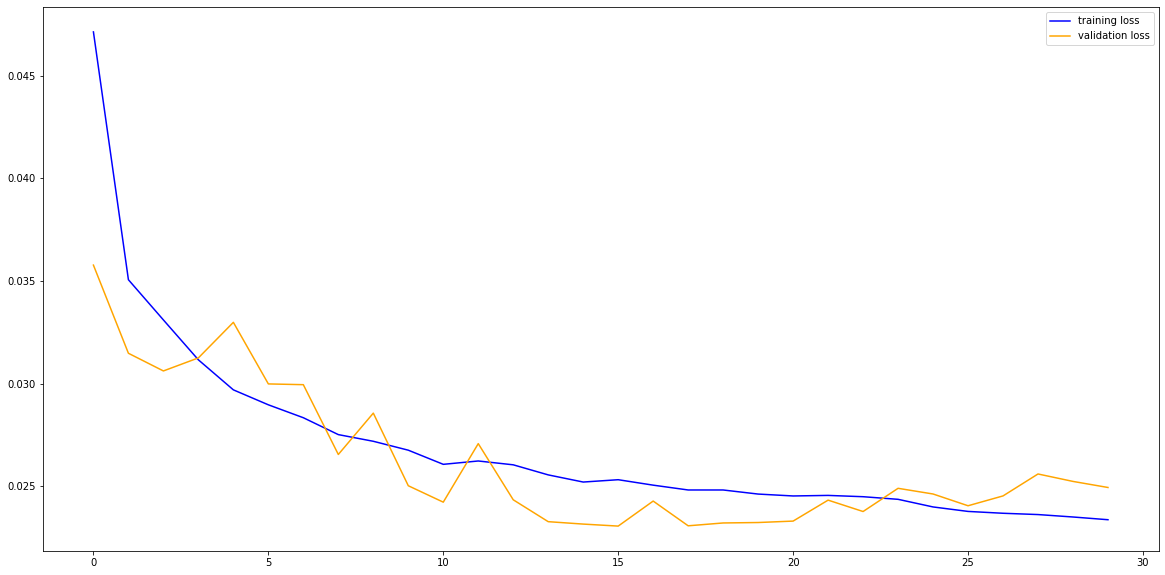

Train on 26304 samples, validate on 8688 samples
Epoch 1/30
26304/26304 [==============================] - 4s 145us/step - loss: 0.0321 - val_loss: 0.0232
Epoch 2/30
26304/26304 [==============================] - 3s 125us/step - loss: 0.0236 - val_loss: 0.0197
Epoch 3/30
26304/26304 [==============================] - 3s 130us/step - loss: 0.0223 - val_loss: 0.0181
Epoch 4/30
26304/26304 [==============================] - 3s 130us/step - loss: 0.0220 - val_loss: 0.0286
Epoch 5/30
26304/26304 [==============================] - 3s 127us/step - loss: 0.0219 - val_loss: 0.0182
Epoch 6/30
26304/26304 [==============================] - 3s 128us/step - loss: 0.0218 - val_loss: 0.0195
Epoch 7/30
26304/26304 [==============================] - 3s 127us/step - loss: 0.0213 - val_loss: 0.0203
Epoch 8/30
26304/26304 [==============================] - 3s 128us/step - loss: 0.0209 - val_loss: 0.0223
Epoch 9/30
26304/26304 [==============================] - 3s 132us/step - loss: 0.0203 - val_loss: 0.02

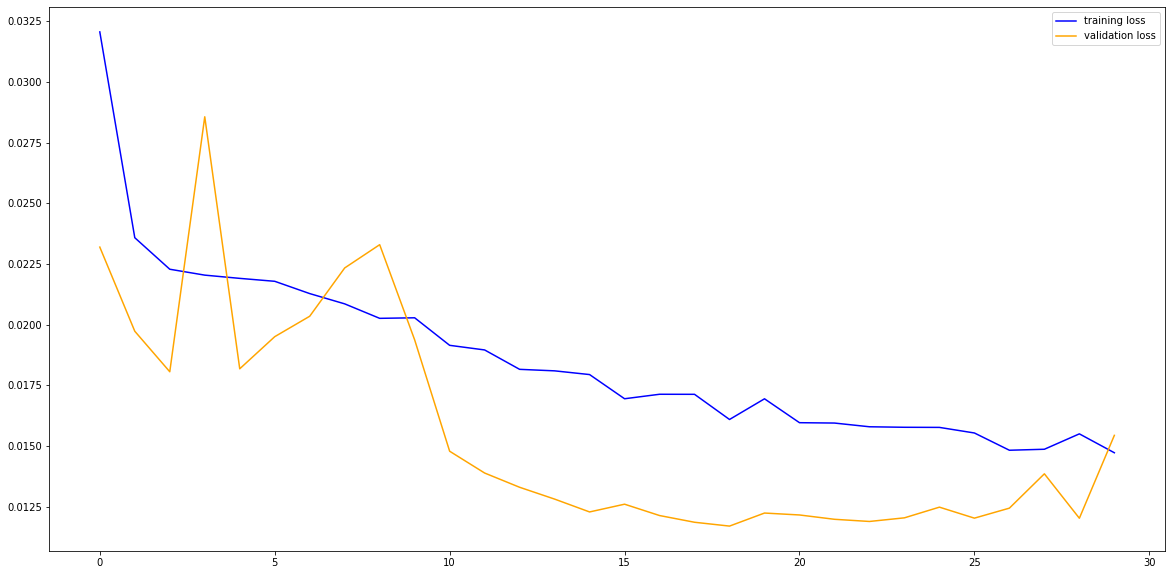

Train on 26304 samples, validate on 8688 samples
Epoch 1/30
26304/26304 [==============================] - 4s 161us/step - loss: 0.1110 - val_loss: 0.1081
Epoch 2/30
26304/26304 [==============================] - 4s 138us/step - loss: 0.0853 - val_loss: 0.0789
Epoch 3/30
26304/26304 [==============================] - 4s 140us/step - loss: 0.0726 - val_loss: 0.0744
Epoch 4/30
26304/26304 [==============================] - 4s 138us/step - loss: 0.0641 - val_loss: 0.0670
Epoch 5/30
26304/26304 [==============================] - 4s 138us/step - loss: 0.0587 - val_loss: 0.0646
Epoch 6/30
26304/26304 [==============================] - 4s 142us/step - loss: 0.0553 - val_loss: 0.0621
Epoch 7/30
26304/26304 [==============================] - 4s 139us/step - loss: 0.0508 - val_loss: 0.0571
Epoch 8/30
26304/26304 [==============================] - 4s 140us/step - loss: 0.0482 - val_loss: 0.0581
Epoch 9/30
26304/26304 [==============================] - 4s 148us/step - loss: 0.0448 - val_loss: 0.05

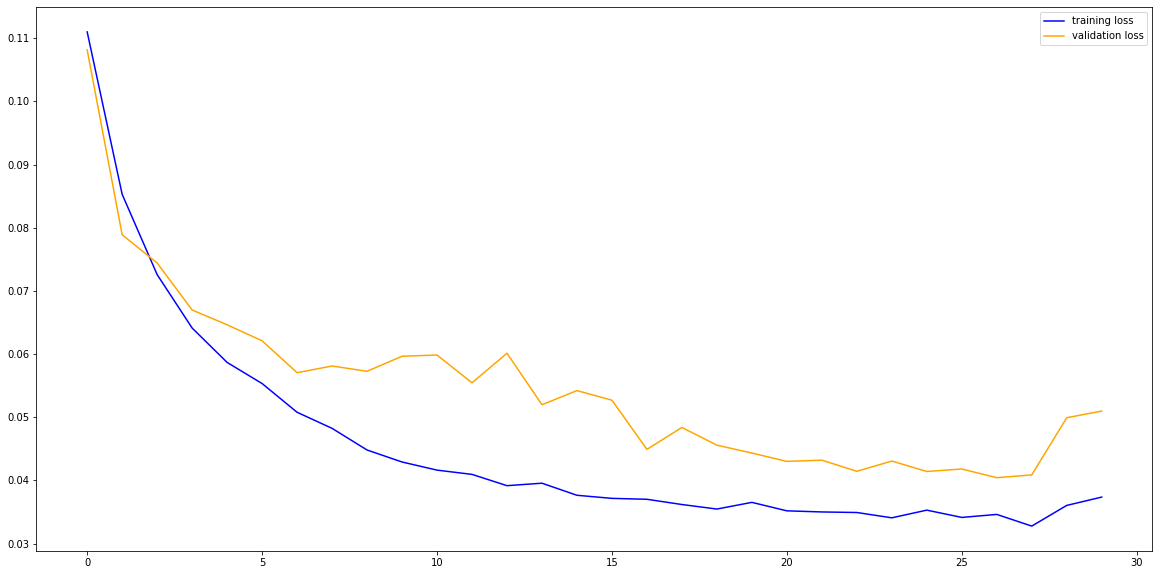

Train on 26304 samples, validate on 8688 samples
Epoch 1/30
26304/26304 [==============================] - 4s 168us/step - loss: 0.0679 - val_loss: 0.1816
Epoch 2/30
26304/26304 [==============================] - 4s 148us/step - loss: 0.0511 - val_loss: 0.1734
Epoch 3/30
26304/26304 [==============================] - 4s 157us/step - loss: 0.0483 - val_loss: 0.1720
Epoch 4/30
26304/26304 [==============================] - 4s 157us/step - loss: 0.0466 - val_loss: 0.1665
Epoch 5/30
26304/26304 [==============================] - 4s 149us/step - loss: 0.0451 - val_loss: 0.1655
Epoch 6/30
26304/26304 [==============================] - 4s 152us/step - loss: 0.0438 - val_loss: 0.1645
Epoch 7/30
26304/26304 [==============================] - 4s 161us/step - loss: 0.0424 - val_loss: 0.1601
Epoch 8/30
26304/26304 [==============================] - 4s 150us/step - loss: 0.0413 - val_loss: 0.1535
Epoch 9/30
26304/26304 [==============================] - 4s 149us/step - loss: 0.0405 - val_loss: 0.14

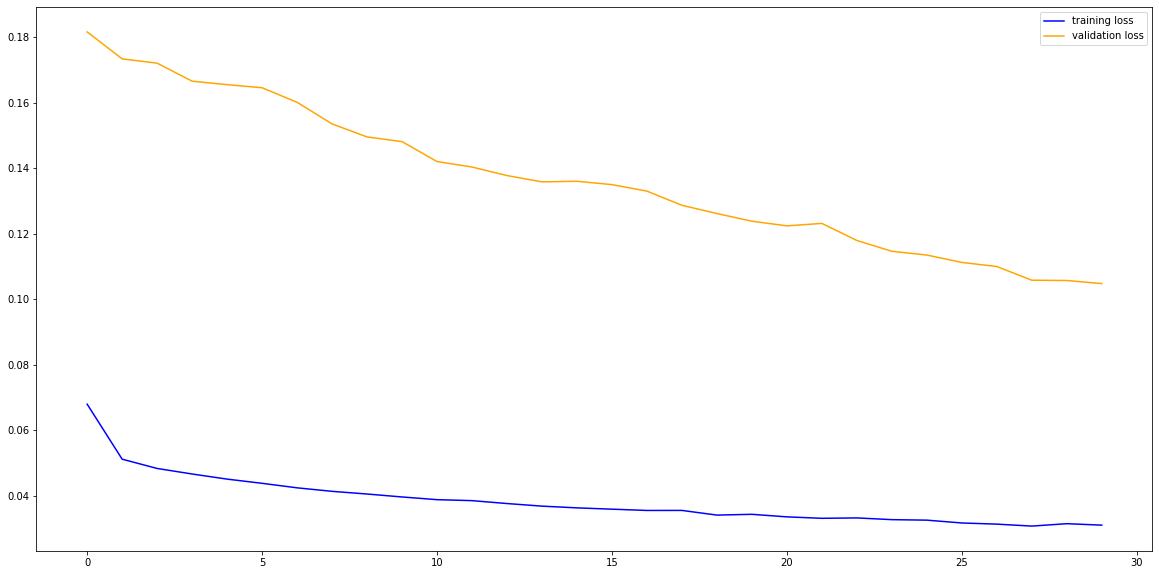

Train on 26304 samples, validate on 8688 samples
Epoch 1/30
26304/26304 [==============================] - 5s 182us/step - loss: 0.1360 - val_loss: 0.1258
Epoch 2/30
26304/26304 [==============================] - 4s 151us/step - loss: 0.1282 - val_loss: 0.1266
Epoch 3/30
26304/26304 [==============================] - 4s 159us/step - loss: 0.1267 - val_loss: 0.1270
Epoch 4/30
26304/26304 [==============================] - 4s 157us/step - loss: 0.1254 - val_loss: 0.1276
Epoch 5/30
26304/26304 [==============================] - 4s 159us/step - loss: 0.1242 - val_loss: 0.1273
Epoch 6/30
26304/26304 [==============================] - 4s 158us/step - loss: 0.1224 - val_loss: 0.1256
Epoch 7/30
26304/26304 [==============================] - 4s 147us/step - loss: 0.1202 - val_loss: 0.1178
Epoch 8/30
26304/26304 [==============================] - 4s 153us/step - loss: 0.1172 - val_loss: 0.1145
Epoch 9/30
26304/26304 [==============================] - 4s 162us/step - loss: 0.1143 - val_loss: 0.11

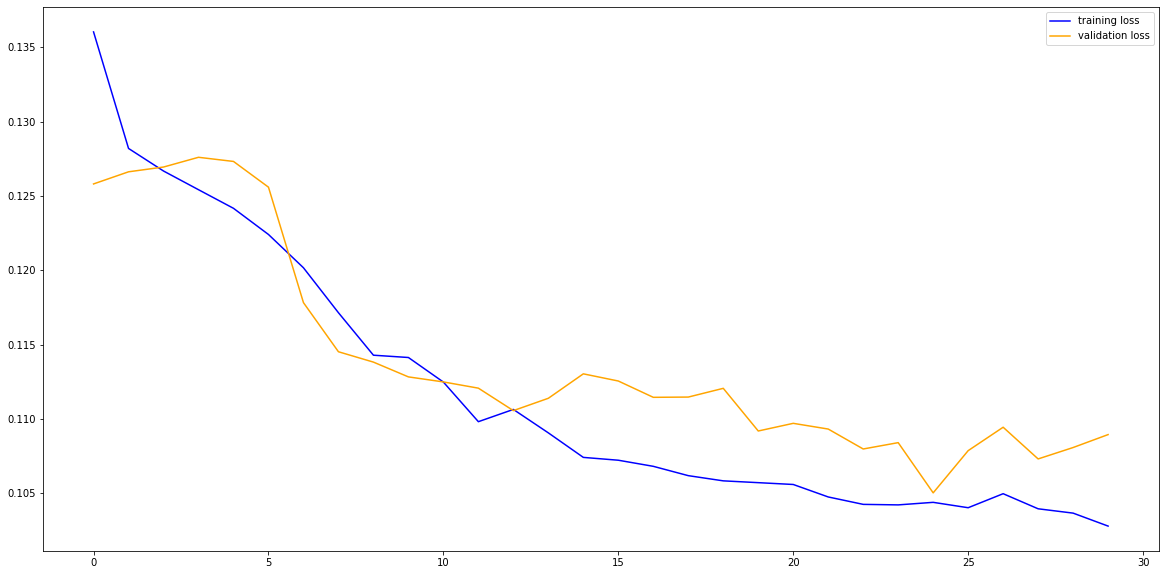

Train on 26304 samples, validate on 8688 samples
Epoch 1/30
26304/26304 [==============================] - 5s 176us/step - loss: 0.0650 - val_loss: 0.0538
Epoch 2/30
26304/26304 [==============================] - 4s 148us/step - loss: 0.0503 - val_loss: 0.0478
Epoch 3/30
26304/26304 [==============================] - 4s 155us/step - loss: 0.0475 - val_loss: 0.0480
Epoch 4/30
26304/26304 [==============================] - 4s 159us/step - loss: 0.0458 - val_loss: 0.0446
Epoch 5/30
26304/26304 [==============================] - 4s 149us/step - loss: 0.0436 - val_loss: 0.0430
Epoch 6/30
26304/26304 [==============================] - 4s 148us/step - loss: 0.0418 - val_loss: 0.0461
Epoch 7/30
26304/26304 [==============================] - 4s 166us/step - loss: 0.0405 - val_loss: 0.0486
Epoch 8/30
26304/26304 [==============================] - 4s 153us/step - loss: 0.0393 - val_loss: 0.0503
Epoch 9/30
26304/26304 [==============================] - 4s 150us/step - loss: 0.0385 - val_loss: 0.04

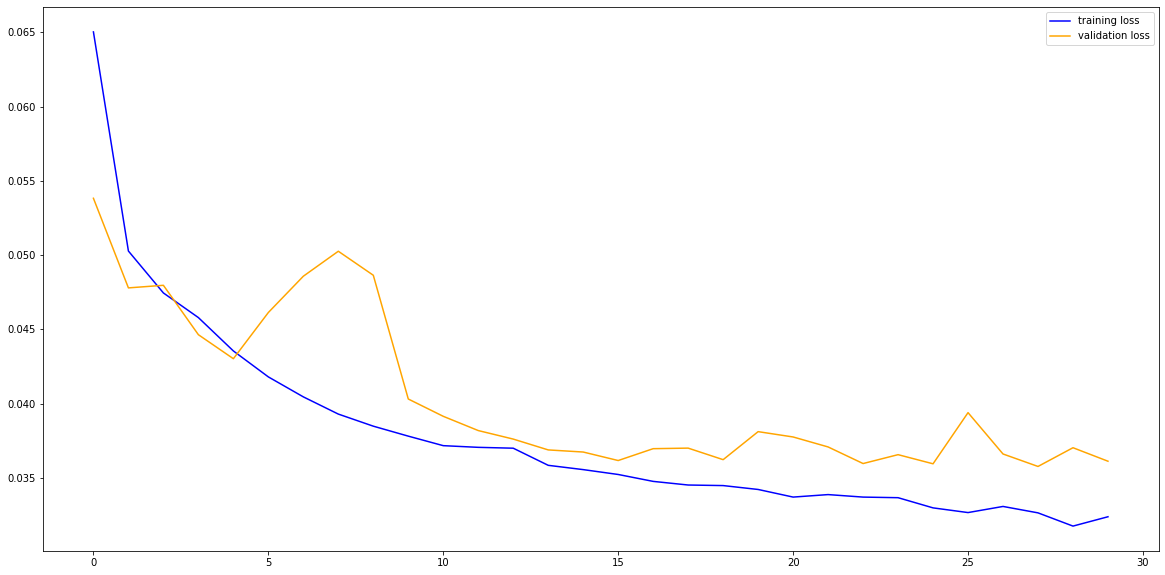

Train on 26304 samples, validate on 8688 samples
Epoch 1/30
26304/26304 [==============================] - 5s 185us/step - loss: 0.0914 - val_loss: 0.0664
Epoch 2/30
26304/26304 [==============================] - 4s 155us/step - loss: 0.0804 - val_loss: 0.0711
Epoch 3/30
26304/26304 [==============================] - 4s 147us/step - loss: 0.0771 - val_loss: 0.0614
Epoch 4/30
26304/26304 [==============================] - 4s 151us/step - loss: 0.0749 - val_loss: 0.0667
Epoch 5/30
26304/26304 [==============================] - 4s 154us/step - loss: 0.0729 - val_loss: 0.0638
Epoch 6/30
26304/26304 [==============================] - 4s 151us/step - loss: 0.0708 - val_loss: 0.0635
Epoch 7/30
26304/26304 [==============================] - 4s 156us/step - loss: 0.0696 - val_loss: 0.0622
Epoch 8/30
26304/26304 [==============================] - 4s 153us/step - loss: 0.0672 - val_loss: 0.0601
Epoch 9/30
26304/26304 [==============================] - 4s 165us/step - loss: 0.0624 - val_loss: 0.05

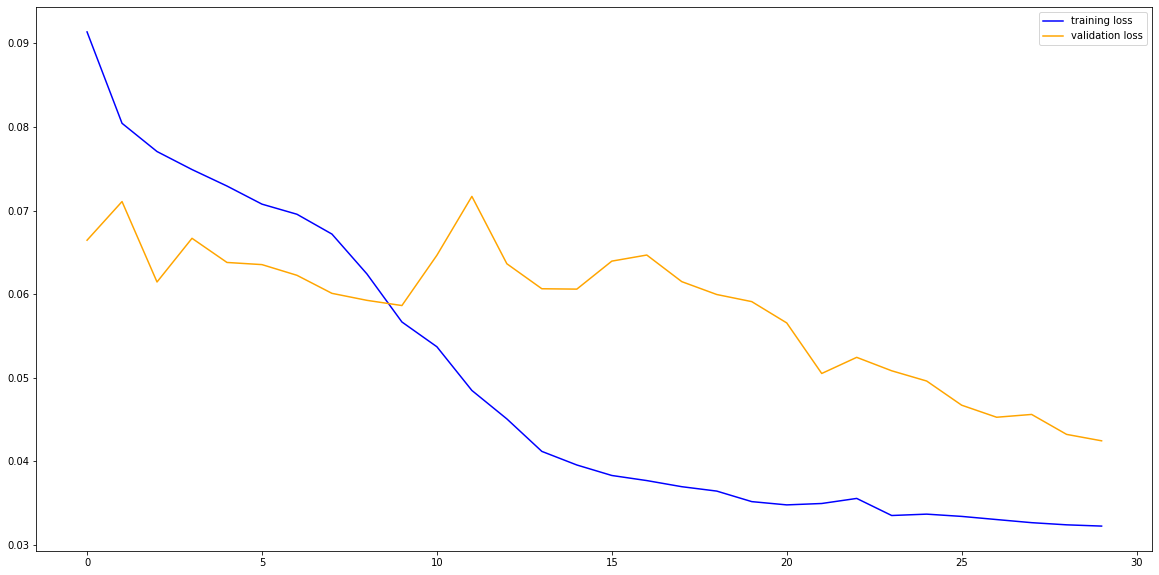

Train on 26304 samples, validate on 8688 samples
Epoch 1/30
26304/26304 [==============================] - 5s 204us/step - loss: 0.0501 - val_loss: 0.0573
Epoch 2/30
26304/26304 [==============================] - 4s 165us/step - loss: 0.0353 - val_loss: 0.0583
Epoch 3/30
26304/26304 [==============================] - 4s 158us/step - loss: 0.0329 - val_loss: 0.0552
Epoch 4/30
26304/26304 [==============================] - 4s 161us/step - loss: 0.0306 - val_loss: 0.0537
Epoch 5/30
26304/26304 [==============================] - 4s 160us/step - loss: 0.0298 - val_loss: 0.0523
Epoch 6/30
26304/26304 [==============================] - 4s 159us/step - loss: 0.0289 - val_loss: 0.0453
Epoch 7/30
26304/26304 [==============================] - 4s 161us/step - loss: 0.0282 - val_loss: 0.0454
Epoch 8/30
26304/26304 [==============================] - 4s 152us/step - loss: 0.0272 - val_loss: 0.0502
Epoch 9/30
26304/26304 [==============================] - 4s 159us/step - loss: 0.0269 - val_loss: 0.04

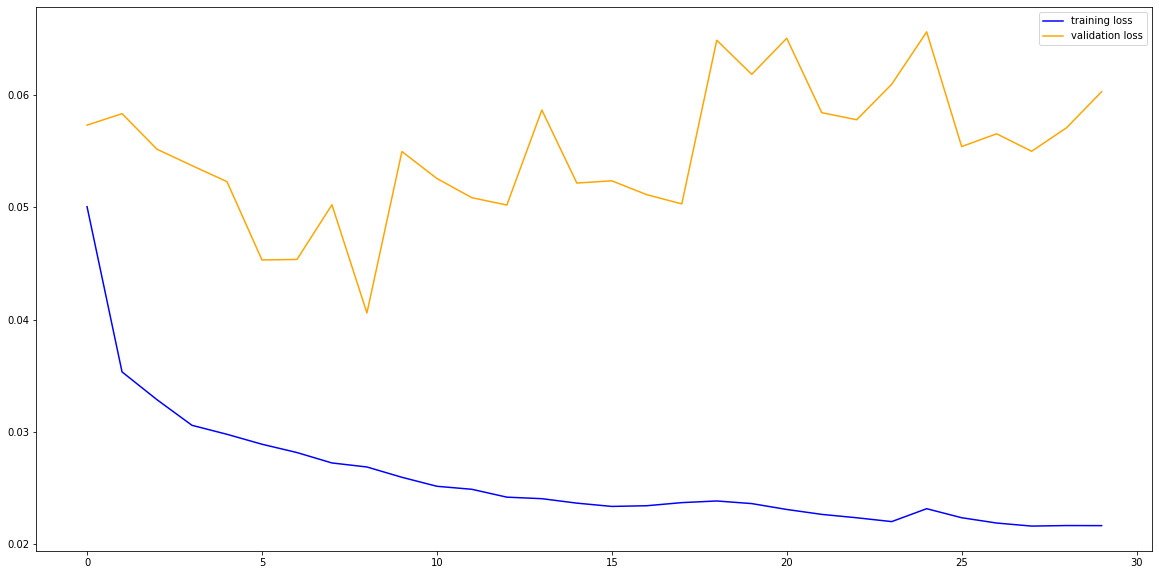

Train on 26304 samples, validate on 8688 samples
Epoch 1/30
26304/26304 [==============================] - 6s 224us/step - loss: 0.0429 - val_loss: 0.0520
Epoch 2/30
26304/26304 [==============================] - 4s 167us/step - loss: 0.0259 - val_loss: 0.0547
Epoch 3/30
26304/26304 [==============================] - 4s 156us/step - loss: 0.0264 - val_loss: 0.0602
Epoch 4/30
26304/26304 [==============================] - 4s 157us/step - loss: 0.0253 - val_loss: 0.0683
Epoch 5/30
26304/26304 [==============================] - 4s 154us/step - loss: 0.0237 - val_loss: 0.0636
Epoch 6/30
26304/26304 [==============================] - 4s 160us/step - loss: 0.0236 - val_loss: 0.0691
Epoch 7/30
26304/26304 [==============================] - 4s 157us/step - loss: 0.0232 - val_loss: 0.0694
Epoch 8/30
26304/26304 [==============================] - 5s 173us/step - loss: 0.0225 - val_loss: 0.0663
Epoch 9/30
26304/26304 [==============================] - 4s 163us/step - loss: 0.0223 - val_loss: 0.06

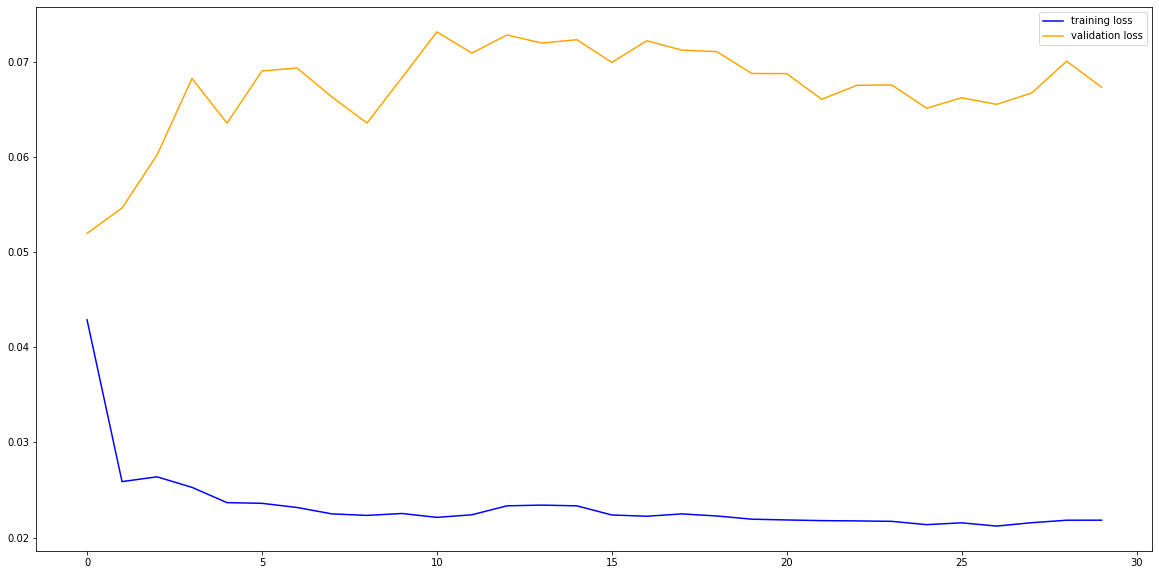

Train on 26304 samples, validate on 8688 samples
Epoch 1/30
26304/26304 [==============================] - 5s 205us/step - loss: 0.0857 - val_loss: 0.1537
Epoch 2/30
26304/26304 [==============================] - 4s 164us/step - loss: 0.0704 - val_loss: 0.1443
Epoch 3/30
26304/26304 [==============================] - 4s 170us/step - loss: 0.0588 - val_loss: 0.1738
Epoch 4/30
26304/26304 [==============================] - 5s 173us/step - loss: 0.0525 - val_loss: 0.1518
Epoch 5/30
26304/26304 [==============================] - 5s 174us/step - loss: 0.0477 - val_loss: 0.1275
Epoch 6/30
26304/26304 [==============================] - 5s 177us/step - loss: 0.0455 - val_loss: 0.1319
Epoch 7/30
26304/26304 [==============================] - 5s 173us/step - loss: 0.0446 - val_loss: 0.1229
Epoch 8/30
26304/26304 [==============================] - 4s 168us/step - loss: 0.0439 - val_loss: 0.1207
Epoch 9/30
26304/26304 [==============================] - 5s 178us/step - loss: 0.0447 - val_loss: 0.11

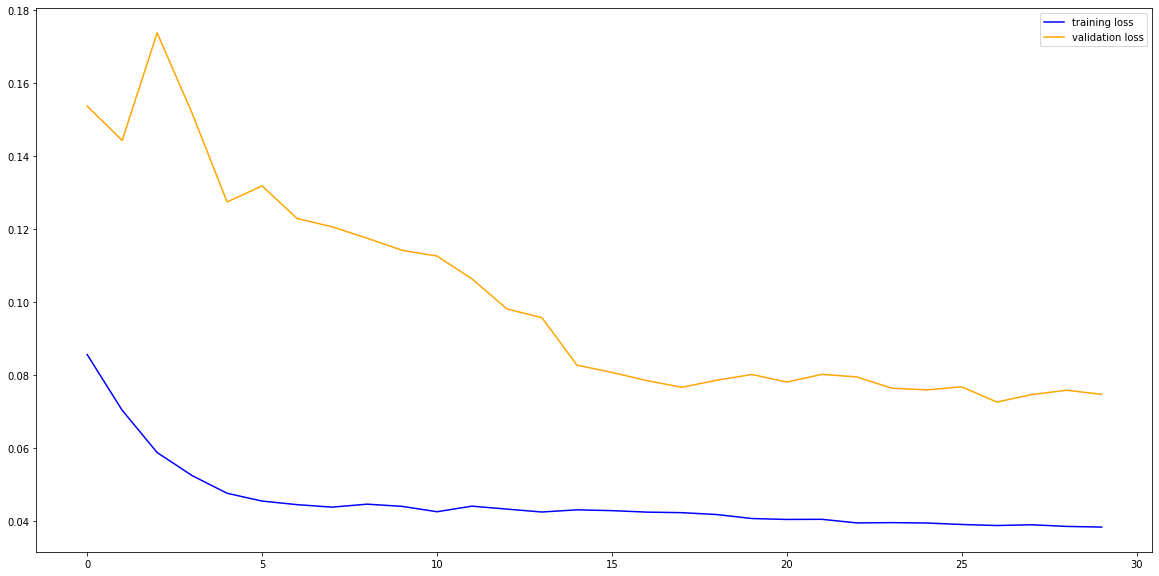

Train on 26304 samples, validate on 8688 samples
Epoch 1/30
26304/26304 [==============================] - 5s 201us/step - loss: 0.0361 - val_loss: 0.0351
Epoch 2/30
26304/26304 [==============================] - 4s 163us/step - loss: 0.0258 - val_loss: 0.0320
Epoch 3/30
26304/26304 [==============================] - 4s 170us/step - loss: 0.0266 - val_loss: 0.0316
Epoch 4/30
26304/26304 [==============================] - 4s 170us/step - loss: 0.0289 - val_loss: 0.0290
Epoch 5/30
26304/26304 [==============================] - 4s 165us/step - loss: 0.0272 - val_loss: 0.0298
Epoch 6/30
26304/26304 [==============================] - 4s 167us/step - loss: 0.0277 - val_loss: 0.0297
Epoch 7/30
26304/26304 [==============================] - 5s 171us/step - loss: 0.0252 - val_loss: 0.0297
Epoch 8/30
26304/26304 [==============================] - 4s 165us/step - loss: 0.0264 - val_loss: 0.0309
Epoch 9/30
26304/26304 [==============================] - 4s 170us/step - loss: 0.0262 - val_loss: 0.03

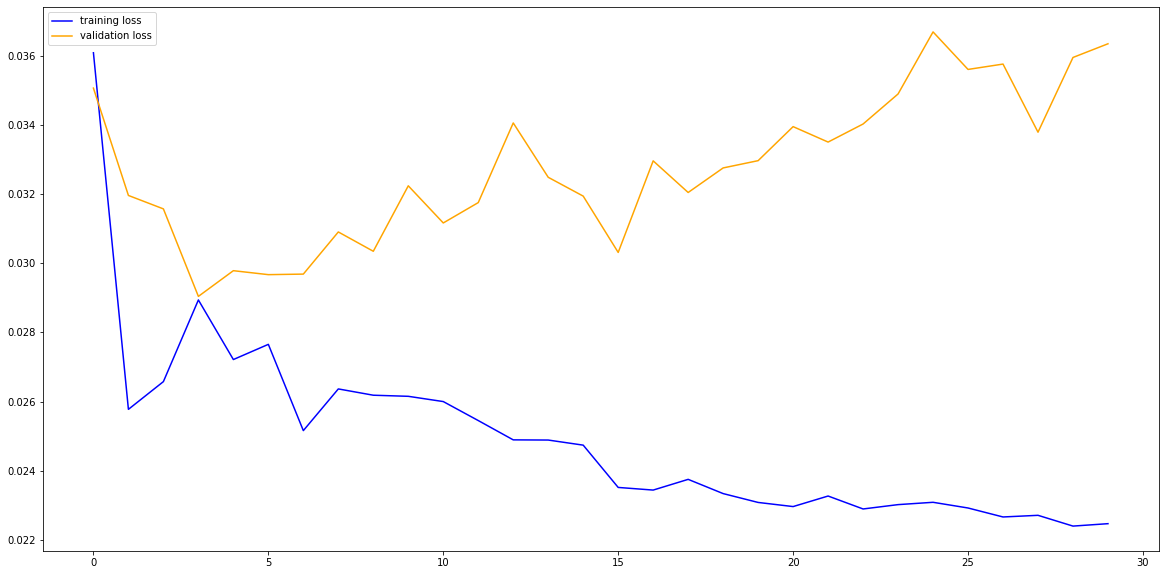

Train on 26304 samples, validate on 8688 samples
Epoch 1/30
26304/26304 [==============================] - 6s 214us/step - loss: 0.0386 - val_loss: 0.0268
Epoch 2/30
26304/26304 [==============================] - 4s 167us/step - loss: 0.0257 - val_loss: 0.0199
Epoch 3/30
26304/26304 [==============================] - 5s 172us/step - loss: 0.0224 - val_loss: 0.0193
Epoch 4/30
26304/26304 [==============================] - 4s 168us/step - loss: 0.0217 - val_loss: 0.0189
Epoch 5/30
26304/26304 [==============================] - 4s 169us/step - loss: 0.0204 - val_loss: 0.0176
Epoch 6/30
26304/26304 [==============================] - 4s 165us/step - loss: 0.0198 - val_loss: 0.0187
Epoch 7/30
26304/26304 [==============================] - 5s 173us/step - loss: 0.0200 - val_loss: 0.0162
Epoch 8/30
26304/26304 [==============================] - 5s 183us/step - loss: 0.0189 - val_loss: 0.0171
Epoch 9/30
26304/26304 [==============================] - 5s 183us/step - loss: 0.0188 - val_loss: 0.01

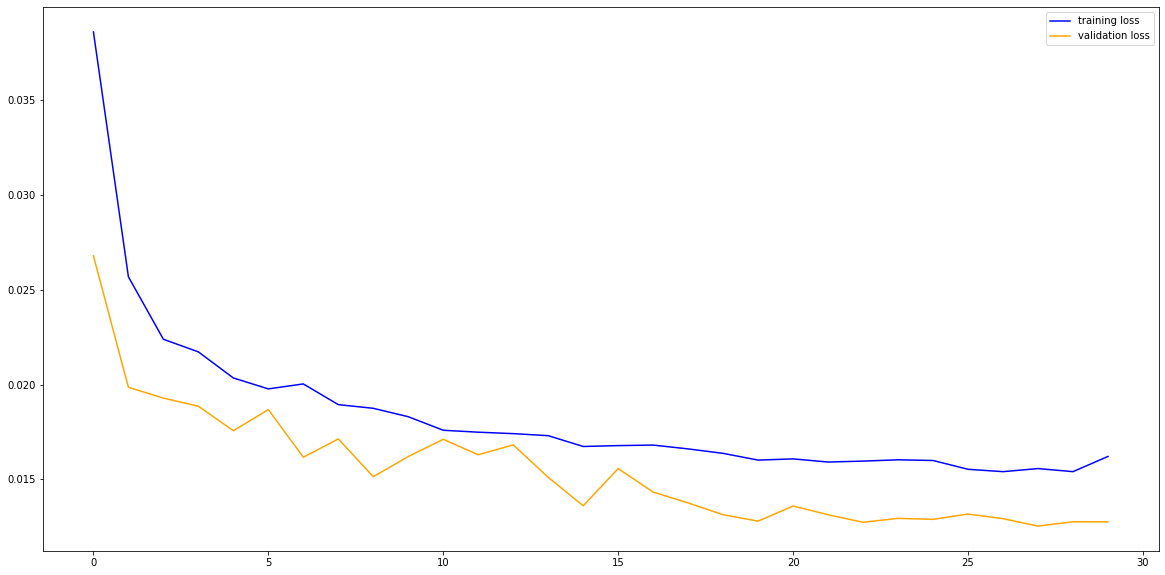

Train on 26304 samples, validate on 8688 samples
Epoch 1/30
26304/26304 [==============================] - 6s 222us/step - loss: 0.0705 - val_loss: 0.0716
Epoch 2/30
26304/26304 [==============================] - 5s 176us/step - loss: 0.0538 - val_loss: 0.0626
Epoch 3/30
26304/26304 [==============================] - 5s 176us/step - loss: 0.0499 - val_loss: 0.0584
Epoch 4/30
26304/26304 [==============================] - 5s 177us/step - loss: 0.0466 - val_loss: 0.0553
Epoch 5/30
26304/26304 [==============================] - 5s 185us/step - loss: 0.0447 - val_loss: 0.0539
Epoch 6/30
26304/26304 [==============================] - 5s 191us/step - loss: 0.0426 - val_loss: 0.0554
Epoch 7/30
26304/26304 [==============================] - 5s 187us/step - loss: 0.0408 - val_loss: 0.0540
Epoch 8/30
26304/26304 [==============================] - 5s 178us/step - loss: 0.0399 - val_loss: 0.0529
Epoch 9/30
26304/26304 [==============================] - 5s 179us/step - loss: 0.0386 - val_loss: 0.05

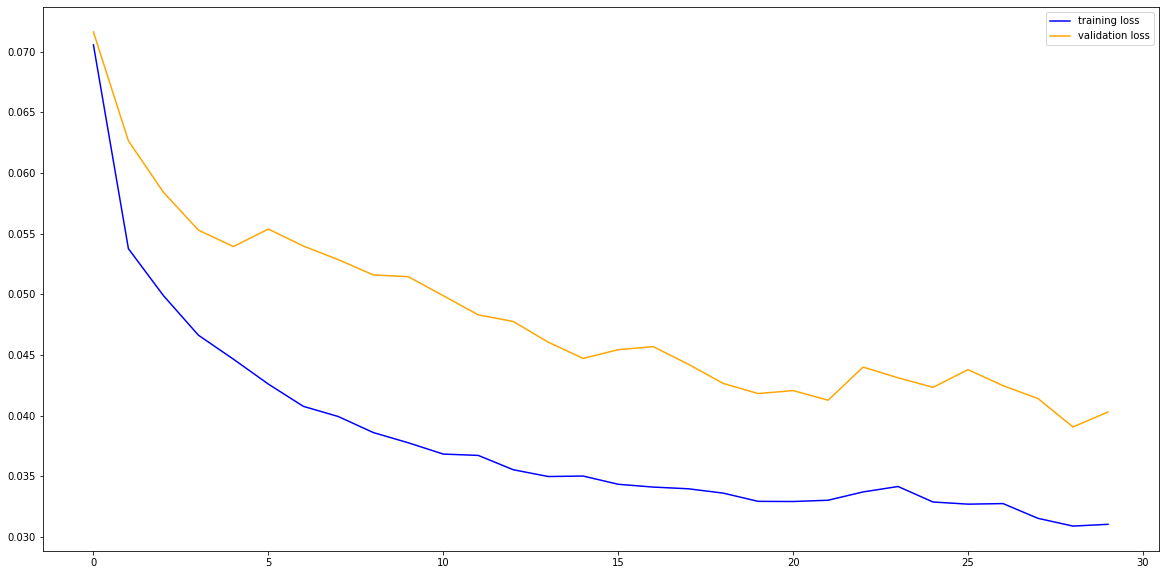

Train on 26304 samples, validate on 8688 samples
Epoch 1/30
26304/26304 [==============================] - 6s 239us/step - loss: 0.0476 - val_loss: 0.0338
Epoch 2/30
26304/26304 [==============================] - 5s 177us/step - loss: 0.0357 - val_loss: 0.0310
Epoch 3/30
26304/26304 [==============================] - 5s 178us/step - loss: 0.0315 - val_loss: 0.0274
Epoch 4/30
26304/26304 [==============================] - 5s 181us/step - loss: 0.0297 - val_loss: 0.0255
Epoch 5/30
26304/26304 [==============================] - 5s 180us/step - loss: 0.0266 - val_loss: 0.0240
Epoch 6/30
26304/26304 [==============================] - 5s 184us/step - loss: 0.0250 - val_loss: 0.0254
Epoch 7/30
26304/26304 [==============================] - 5s 184us/step - loss: 0.0273 - val_loss: 0.0221
Epoch 8/30
26304/26304 [==============================] - 5s 187us/step - loss: 0.0246 - val_loss: 0.0263
Epoch 9/30
26304/26304 [==============================] - 5s 182us/step - loss: 0.0242 - val_loss: 0.02

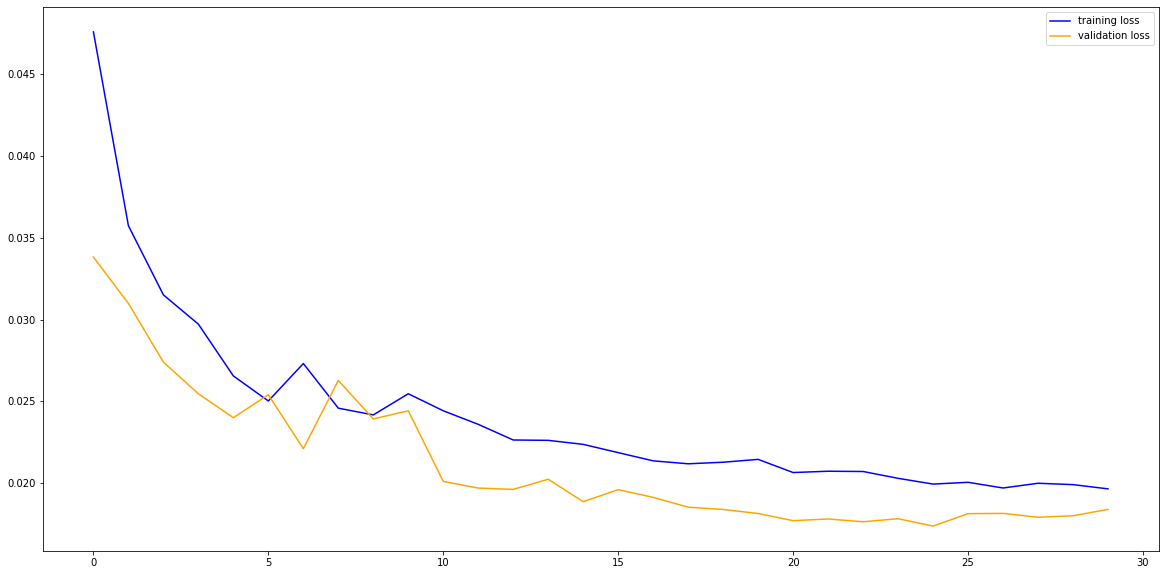

In [119]:
#all features to create model
features = ['pm10_st0','pm25_st0', 'pmco_st0','so2_st0', 'rh_st0', 'tmp_st0','wdr_st0',
           'wsp_st0', 'pa_st0',   'uva_st0', 'uvb_st0', 'dewp_st0',
           'co_st0', 'no_st0','no2_st0', 'nox_st0', 'o3_st0']

for feature in features:
    
    #set feature to be predicted
    columns =  get_corresponding_model_columns(feature)   
    #train using 3 years (2016 to 2018) and let 1 year (2019) to validate    
    train_multi_lstm       = df_workspace[columns]['2016-01-01':'2019-12-31']
    train_hours_multi_lstm = len(train_multi_lstm)
    n_features             = len(train_multi_lstm.columns)
    
    reframed = reframe(train_multi_lstm)
    scaled   = scale(reframed)
    [train_X, train_y, val_X, val_y] = get_train_and_validation(train_hours_multi_lstm, 
                                                                8760, #2019 total hours
                                                                scaled)
    
    [model, history] = fit_multi_lstm(n_features, 
                                      train_X, 
                                      train_y,  
                                      val_X, 
                                      val_y, 
                                      72, 
                                      30, 
                                      n_features*4)
    # plot history
    plot_results(history.history['loss'], 
                 history.history['val_loss'],
                 'training loss', 
                 'validation loss')
    model.save("lstm_multi_model_"+feature+".pkl")

In [107]:
#test to forecast 1 hour given 72 hours in the future, pass the last 3 days in sample
#and predict 1 hour into the future

feature = 'pm10_st0'
scaler = MinMaxScaler(feature_range=(0, 1))
input_t_reframed = 24*3
columns = get_corresponding_model_columns(feature)
#the first column is the one that model predicts
values = df_workspace[columns]['2019-12-28 23:00:00':'2019-12-31 23:00:00'].values
print(len(values))
reframed = series_to_supervised(values, input_t_reframed, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[-18,-17,-16,-15,-14,-13,-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1]], axis=1, inplace=True)
# split into train and test sets
values = reframed.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(values[:,:-1])
scaled_label = scaler.fit_transform(values[:,-1].reshape(-1,1))
values = np.column_stack((scaled_features, scaled_label))
#model needs 3 years of previous data
print(len(values))
train = values[: len(values), :]  #pass all trained values
# split into input and outputs
# features take all values except the var1
train_X, train_y = train[:, :-1], train[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
#predict unseen data
yhat = model.predict(train_X)
#convert back
train_X = train_X.reshape((train_X.shape[0], train_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, train_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
#create dataframe with future data and corresponfing date
dtf = pd.DataFrame (inv_yhat, columns = ['Future'])
dtf['date'] = pd.date_range(start='2020-01-01 00:00:00', freq='1H', periods=len(inv_yhat))
dtf.set_index('date', inplace=True)
dtf

73
1


,Future
date,
2020-01-01,92.508874


In [108]:
df_workspace[feature]['2019-12-30 00:00:00':'2019-12-31 23:00:00'].tail()

date
2019-12-31 19:00:00    66.5
2019-12-31 20:00:00    70.5
2019-12-31 21:00:00    59.5
2019-12-31 22:00:00    78.5
2019-12-31 23:00:00    92.5
Name: pm10_st0, dtype: float64

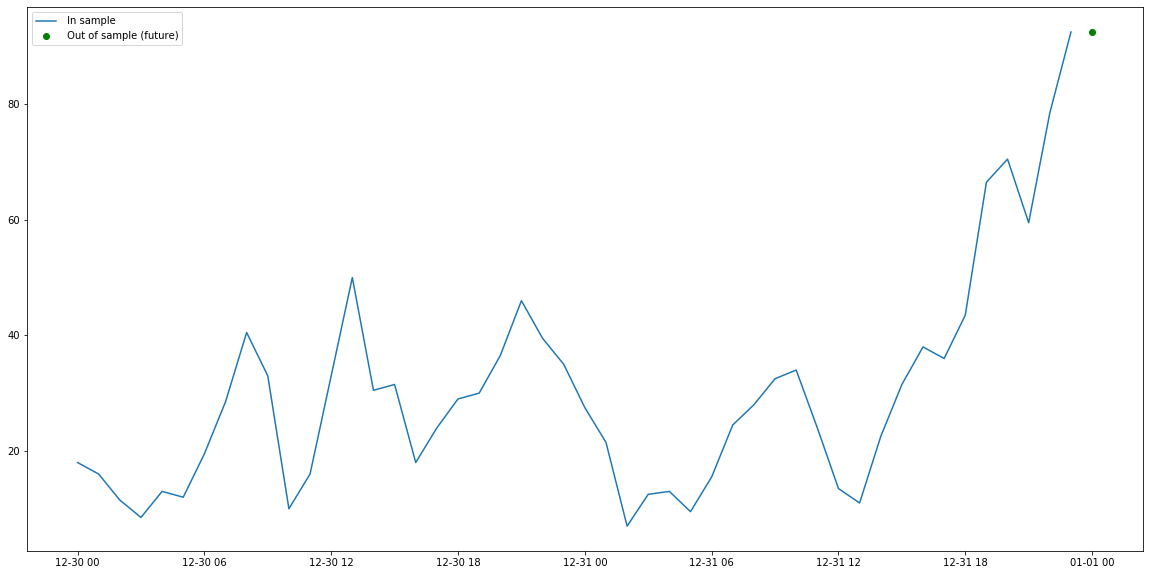

In [110]:
plt.figure(figsize=(20,10))
plt.plot(df_workspace[feature]['2019-12-30 00:00:00':'2019-12-31 23:00:00'], label= " In sample")
plt.plot(dtf,'go',  label=  " Out of sample (future)")
plt.legend(loc="upper left")
plt.show()

# Out of sample forecasting for app

In [153]:
#to know the future hour
def get_next_hour(previous_hour):
    return (previous_hour + 1) % 24

#to know the future week day
def get_next_week_day(hour, week_day):
    if hour == 0:
        return (week_day + 1) % 7
    else :
        return week_day
      
day = 5
for i in range (0,49):
    next_hour = get_next_hour(i)
    day  =  get_next_week_day(next_hour, day)
    print(i%24, next_hour, day)


0 1 5
1 2 5
2 3 5
3 4 5
4 5 5
5 6 5
6 7 5
7 8 5
8 9 5
9 10 5
10 11 5
11 12 5
12 13 5
13 14 5
14 15 5
15 16 5
16 17 5
17 18 5
18 19 5
19 20 5
20 21 5
21 22 5
22 23 5
23 0 6
0 1 6
1 2 6
2 3 6
3 4 6
4 5 6
5 6 6
6 7 6
7 8 6
8 9 6
9 10 6
10 11 6
11 12 6
12 13 6
13 14 6
14 15 6
15 16 6
16 17 6
17 18 6
18 19 6
19 20 6
20 21 6
21 22 6
22 23 6
23 0 0
0 1 0


In [159]:
from keras.models import load_model

#load all models once

model_CO  =  load_model("lstm_multi_model_co_st0.pkl")
model_NO  =  load_model("lstm_multi_model_no_st0.pkl")  
model_NO2 =  load_model("lstm_multi_model_no2_st0.pkl")  
model_NOX =  load_model("lstm_multi_model_nox_st0.pkl")  
model_O3  =  load_model("lstm_multi_model_o3_st0.pkl")   
model_PM10=  load_model("lstm_multi_model_pm10_st0.pkl") 
model_PM25=  load_model("lstm_multi_model_pm25_st0.pkl") 
model_PMCO=  load_model("lstm_multi_model_pmco_st0.pkl") 
model_SO2 =  load_model("lstm_multi_model_so2_st0.pkl") 
model_RH  =  load_model("lstm_multi_model_rh_st0.pkl")   
model_TMP =  load_model("lstm_multi_model_tmp_st0.pkl") 
model_WDR =  load_model("lstm_multi_model_wdr_st0.pkl")  
model_WSP =  load_model("lstm_multi_model_wsp_st0.pkl")  
model_UVA =  load_model("lstm_multi_model_uva_st0.pkl")   
model_UVB =  load_model("lstm_multi_model_uvb_st0.pkl")   
model_PA  =  load_model("lstm_multi_model_pa_st0.pkl")    
model_DEW =  load_model("lstm_multi_model_dewp_st0.pkl")    

multi_model_dictionary = {   'co_st0'   : model_CO, 
                             'no_st0'   : model_NO,
                             'no2_st0'  : model_NO2,
                             'nox_st0'  : model_NOX,
                             'o3_st0'   : model_O3,
                             'pm10_st0' : model_PM10,
                             'pm25_st0' : model_PM25,
                             'pmco_st0' : model_PMCO,
                             'so2_st0'  : model_SO2,
                             'rh_st0'   : model_RH,
                             'tmp_st0'  : model_TMP,
                             'wdr_st0'  : model_WDR,
                             'wsp_st0'  : model_WSP,
                             'uva_st0'  : model_UVA,
                             'uvb_st0'  : model_UVB,
                             'pa_st0'   : model_PA,
                             'dewp_st0' : model_DEW
                           }


In [170]:
def get_corresponding_model(feature):
    return multi_model_dictionary.get(feature)

#'2019-12-28 23:00:00':'2019-12-31 23:00:00'
#there must be a 3 day diff between these dates
def get_future_value(df, feature, start_date, end_date):
    scaler = MinMaxScaler(feature_range=(0, 1))
    input_t_reframed = 24*3

    #load corresponding model data
    columns = get_corresponding_model_columns(feature)
    model   = get_corresponding_model(feature)
    
    #the first column is the one that model predicts
    values = df[columns][start_date:end_date].values
    reframed = series_to_supervised(values, input_t_reframed, 1)
    # drop columns we don't want to predict
    reframed.drop(reframed.columns[[-18,-17,-16,-15,-14,-13,-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1]], axis=1, inplace=True)
    # split into train and test sets
    values = reframed.values
    scaled_features = scaler.fit_transform(values[:,:-1])
    scaled_label = scaler.fit_transform(values[:,-1].reshape(-1,1))
    values = np.column_stack((scaled_features, scaled_label))
    #model needs 3 years of previous data
    #print(len(values))
    train = values[: len(values), :]  #pass all trained values
    # split into input and outputs
    # features take all values except the var1
    train_X, train_y = train[:, :-1], train[:, -1]
    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    #predict unseen data
    yhat = model.predict(train_X)
    #convert back
    train_X = train_X.reshape((train_X.shape[0], train_X.shape[2]))
    # invert scaling for forecast
    inv_yhat = concatenate((yhat, train_X[:, 1:]), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]
    return inv_yhat[0]

In [171]:
#use method  to forecast pm10_st0
forecasted = get_future_value(df_workspace,'pm10_st0', '2019-12-28 23:00:00', '2019-12-31 23:00:00') 
forecasted

92.51786716282368

In [172]:
#use method  to forecast o3_st0
forecasted = get_future_value(df_workspace,'o3_st0', '2019-12-28 23:00:00', '2019-12-31 23:00:00') 
forecasted

11.108874274790287

In [ ]:
#so far so good!!!

In [173]:
df_hour_weekday = df_workspace[['weekday', 'hora']].loc['2019-12-31 23:00:00']
print(df_hour_weekday.hora)
print(df_hour_weekday.weekday)


23
1


In [175]:
#'2019-12-28 23:00:00', '2019-12-31 23:00:00'
def predict_all_features(df, start_date, end_date):
    
    df_hour_weekday = df[['weekday', 'hora']].loc[end_date]
    features = ['pm10_st0','pm25_st0', 'pmco_st0','so2_st0', 'rh_st0', 'tmp_st0','wdr_st0',
                'wsp_st0', 'pa_st0',   'uva_st0', 'uvb_st0', 'dewp_st0',
                'co_st0', 'no_st0','no2_st0', 'nox_st0', 'o3_st0']
    results  = []
    pm10_st0 = get_future_value(df,'pm10_st0', start_date, end_date)
    pm25_st0 = get_future_value(df,'pm25_st0', start_date, end_date)
    pmco_st0 = get_future_value(df,'pmco_st0', start_date, end_date)
    so2_st0  = get_future_value(df,'so2_st0',  start_date, end_date)
    rh_st0   = get_future_value(df,'rh_st0',   start_date, end_date)
    tmp_st0  = get_future_value(df,'tmp_st0',  start_date, end_date)
    wdr_st0  = get_future_value(df,'wdr_st0',  start_date, end_date)
    wsp_st0  = get_future_value(df,'wsp_st0',  start_date, end_date)
    pa_st0   = get_future_value(df,'pa_st0',   start_date, end_date)
    uva_st0  = get_future_value(df,'uva_st0',  start_date, end_date)
    uvb_st0  = get_future_value(df,'uvb_st0',  start_date, end_date)
    dewp_st0 = get_future_value(df,'dewp_st0', start_date, end_date)
    co_st0   = get_future_value(df,'co_st0',   start_date, end_date)
    no_st0   = get_future_value(df,'no_st0',   start_date, end_date)
    no2_st0  = get_future_value(df,'no2_st0',  start_date, end_date)
    nox_st0  = get_future_value(df,'nox_st0',  start_date, end_date)
    o3_st0   = get_future_value(df,'o3_st0',   start_date, end_date)
    hour     = get_next_hour(df_hour_weekday.hora)
    weekday  = get_next_week_day(df_hour_weekday.hora, df_hour_weekday.weekday)
    results.append([pm10_st0,pm25_st0, pmco_st0, so2_st0, rh_st0, tmp_st0, wdr_st0,
                    wsp_st0, pa_st0,   uva_st0, uvb_st0, dewp_st0,
                    co_st0, no_st0,no2_st0, nox_st0, o3_st0,
                    hour,weekday])
      
    return results

In [176]:
test_prediction = predict_all_features(df_workspace,'2019-12-28 23:00:00', '2019-12-31 23:00:00')
test_prediction

[[92.51786716282368,
  34.54459271579981,
  23.0942215770483,
  6.071639174776077,
  57.14764781356454,
  15.742759528154135,
  172.33519920516014,
  3.890367017612457,
  584.9919137222766,
  0.0017309027025476098,
  0.002051564631983638,
  6.321647764382362,
  3.910223442316055,
  8.888147603720427,
  31.688538870215417,
  36.403946813195944,
  11.108874274790287,
  0,
  1]]

In [ ]:
#result is correct

In [190]:


def multivariate_lstm_future(df,
                             start_date, 
                             end_date,
                             step_to_predict_future):

    columns=['pm10_st0','pm25_st0', 'pmco_st0','so2_st0', 'rh_st0', 
             'tmp_st0','wdr_st0',   'wsp_st0', 'pa_st0',   'uva_st0',
             'uvb_st0', 'dewp_st0', 'co_st0', 'no_st0','no2_st0', 
             'nox_st0', 'o3_st0', 
             'hora','weekday']
    
    df_sub_copy = df[start_date:end_date][columns].copy() 
    for i in range(step_to_predict_future):
        #predict features and move frame one step after appending results
        test_prediction = predict_all_features(df_workspace,start_date, end_date)
        df_sub_copy.append(pd.DataFrame(data=test_prediction, index=[last_date]))
        
        #add 1 hour to start date and end date
        
        
    return df_sub_copy
    

In [192]:
#'2019-12-28 23:00:00': '2019-12-31 23:00:00'
#result = multivariate_lstm_future(df_workspace, '2019-12-28 23:00:00', '2019-12-31 23:00:00',1)
#result